# Last-mile Delivery Scheduling and Rescheduling
### Weixuan Yang, Qin Deng, Hanyu Xi
##### The Edward S. Rogers Sr. Department of Electrical & Computer Engineering, University of Toronto
##### {weixuan.yang, davy.deng, hanyuxi}@mail.utoronto.ca

In [191]:
import os
import time
import json
import random
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import geopandas
import networkx
import warnings
import ipyleaflet as lf
from sklearn.cluster import KMeans
from smart_mobility_utilities.viz import draw_route, draw_map
from datetime import datetime
from smart_mobility_utilities.common import random_tour
from smart_mobility_utilities.problem import PMX_crossover, insert_mutation
from tqdm.notebook import tqdm
from seaborn import scatterplot, color_palette

warnings.simplefilter(action='ignore', category=FutureWarning)
tf.get_logger().setLevel('ERROR')

## Parameters

In [4]:
# Customer parameters
param_unit_cost = 8.0
param_wait_cost = 0.5
param_delay_cost = 1.5
param_vehicle_capacity = 3313071*0.6*0.2
param_work_time = 3*60*60
param_depot = 'FJ'
# K-means clustering parameters
param_cluster_ngen = 100
# Genetic algorithm parameters
param_size_of_population = 100
param_ngen = 500
param_mut_prob = 0.3
param_cro_prob = 0.7

## Dataset preprocess

In [5]:
raw_data = pd.read_csv('data\DLA7_package_data.csv', index_col=[0])
package_data = pd.DataFrame(columns=['loc_lat','loc_lng','dim_depth_cm','dim_height_cm','dim_width_cm','tim_start','tim_end','tim_plan_sec'])
loc_data = pd.read_csv('data\DLA7_stop_data.csv', index_col=[0])
time_data = pd.read_csv('data\DLA7_travel_data.csv', index_col=[0])
for index, row in raw_data.iterrows():
    if index not in loc_data.index:
        continue
    for column in row[row.notna()]:
        if column == "{}":
            continue
        column = json.loads(column.replace("'", '"').replace("nan",'"nan"'))
        for id in column.keys():
            package = pd.DataFrame(data=[{"label": index,
                    'loc_lat': loc_data.loc[index,'lat'],
                    'loc_lng': loc_data.loc[index,'lng'],
                    'dim_depth_cm': column[id]['dimensions']['depth_cm'],
                    'dim_height_cm': column[id]['dimensions']['height_cm'],
                    'dim_width_cm': column[id]['dimensions']['width_cm'],
                    'volume': column[id]['dimensions']['depth_cm']*column[id]['dimensions']['height_cm']*column[id]['dimensions']['width_cm'],
                    'tim_start': column[id]['time_window']['start_time_utc'],
                    'tim_end': column[id]['time_window']['end_time_utc'],
                    'tim_plan_sec': column[id]['planned_service_time_seconds']}], index=[id.replace('PackageID_','')])
        package_data = package_data.append(package)
package_data.index.name = 'id'
package_data.head()

,loc_lat,loc_lng,dim_depth_cm,dim_height_cm,dim_width_cm,tim_start,tim_end,tim_plan_sec,label,volume
id,,,,,,,,,,
2baf8350-32fe-4b39-9b22-c4c262888095,33.785869,-117.802461,30.2,2.8,27.7,nan,nan,70.0,AU,2342.312
b4602d93-e3e0-4aab-909a-bed9b8829850,33.785869,-117.802461,49.5,7.6,35.6,nan,nan,49.0,AU,13392.720
45db3aca-ae02-42a4-84a7-36b9e38e0ed1,33.786393,-117.825913,34.0,6.6,17.0,nan,nan,238.0,AV,3814.800
1f3eb06c-1dd1-4a4e-912d-b334b2504f61,33.786393,-117.825913,34.3,11.4,20.3,nan,nan,59.0,AV,7937.706
e9a647b0-0194-4a31-9110-0ad4e324cefb,33.784522,-117.816622,43.2,7.6,27.9,nan,nan,90.0,AY,9160.128


In [6]:
def get_travel_time(a, b):
  """Get the travel time between two points

    Args:
      a (str): the code for the first point
      b (str): the code for the second point

    Returns:
      float: the travel time between the two points
  """
  try:
    travel_time = time_data.loc[a, b]
  except:
    travel_time = time_data.loc[b, a]
  if pd.isna(travel_time):
    raise ValueError('Starting point and destination pair does not exist.')
  return travel_time

## Depot and drop-off location visualization

In [7]:
import osmnx
import folium

depot = [33.965477, -117.653303] # DLA7 amazon warehouse
customer_map = folium.Map(location=depot, zoom_start=11)

locations = package_data[['loc_lat', 'loc_lng']]
location_list = locations.values.tolist()

for point in range(0, len(location_list)):
    folium.Marker(location_list[point]).add_to(customer_map)
folium.Marker(depot, icon=folium.Icon(color="red", icon="info-sign")).add_to(customer_map)
customer_map

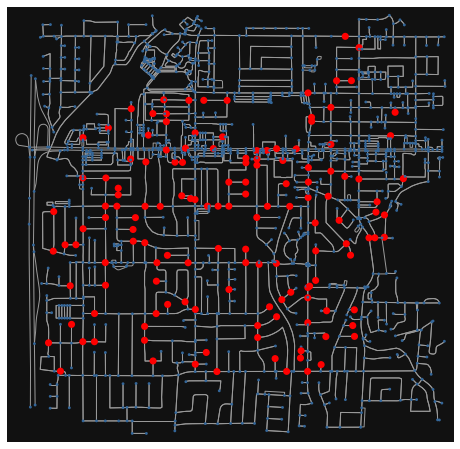

In [8]:
# Choose collection place with index 2 and drop-off list with index 21, 25
X = [l[0] for l in location_list]
Y = [l[1] for l in location_list]
center = (sum(X)/len(X), sum(Y)/len(X))
# Get the graph
graph = osmnx.graph_from_point(center, dist=1500)
nodes, edges = osmnx.graph_to_gdfs(graph)
closest_nodes = osmnx.distance.nearest_nodes(graph,Y,X)
# Marking both the source and destination node
nc = ['red' if node in closest_nodes else '#336699' for node in graph.nodes()]
ns = [50 if node in closest_nodes else 8 for node in graph.nodes()]
fig, ax = osmnx.plot_graph(graph, node_size=ns, node_color=nc, node_zorder=2)

## K-means clustering

In [225]:
class ClusterSolver:
    def __init__(self, df_package, ngen):
        self.package_data = df_package
        self.points = df_package.loc[:,['loc_lat', 'loc_lng']]
        self.ngen = ngen
        self.n_clusters = 2
    def get_assignment(self):
        assignment = []
        for i in range(self.n_clusters):
            assignment.append(self.package_data[self.points['assignment'] == i])
        return assignment
    def convert_input(self):
        return tf.compat.v1.train.limit_epochs(tf.convert_to_tensor(self.points, dtype=tf.float32), num_epochs=1)
    def run(self):
        while True:
            satisfied = True
            kmeans = KMeans(n_clusters = self.n_clusters, algorithm='auto')
            for _ in range(self.ngen):
                self.points['assignment'] = kmeans.fit_predict(self.points)
                for cluster_index in np.unique(self.points['assignment']):
                    if self.package_data[self.points['assignment'] == cluster_index]['volume'].sum() > param_vehicle_capacity:
                        satisfied = False
                if satisfied:
                    break
            if satisfied:
                break
            self.n_clusters += 1
        scatterplot(data=self.points, x='loc_lat', y='loc_lng', hue='assignment', palette=color_palette("tab10", self.n_clusters))
        plt.show()

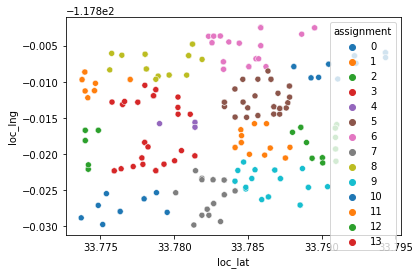

In [226]:
k_solver = ClusterSolver(package_data, param_cluster_ngen)
k_solver.run()

## Genetic algorithm

In [202]:
class GeneSolver:
    def __init__(self, df_package, size_of_population, ngen, unit_cost, wait_cost, delay_cost, vehicle_capacity, work_time, depot_code, mut_prob, cro_prob):
        self.package_data = df_package
        self.pool = [*random_tour(range(self.package_data.shape[0]), number_of_perms=size_of_population)]
        self.size_of_population = size_of_population
        self.ngen = ngen
        self.unit_cost = unit_cost
        self.wait_cost = wait_cost
        self.delay_cost = delay_cost
        self.vehicle_capacity = vehicle_capacity
        self.work_time = work_time
        self.depot = depot_code
        self.mut_prob = mut_prob
        self.cro_prob = cro_prob

    def crossover(self, arg1, arg2):
        return PMX_crossover(arg1, arg2)

    def mutate(self, arg):
        return insert_mutation(arg)

    def convert_ind2route(self, individual):
    # transform a list of customer/package id to several routes that meet the capacity limit and time window
        this_route = []
        sub_route = []
        vehicle_load = 0
        elapsed_time = 0
        last_customer_id = -1
        for customer_id in individual:
            # Update vehicle load
            demand = self.package_data.iloc[customer_id].volume
            updated_vehicle_load = vehicle_load + demand
            # Update elapsed time
            service_time = self.package_data.iloc[customer_id].tim_plan_sec
            return_time = get_travel_time(self.package_data.iloc[customer_id].label, self.depot)
            if last_customer_id != -1:
                updated_elapsed_time = elapsed_time + \
                    get_travel_time(self.package_data.iloc[last_customer_id].label, self.package_data.iloc[customer_id].label)+ service_time
            else:
                updated_elapsed_time = get_travel_time(self.depot, self.package_data.iloc[customer_id].label) + service_time + return_time
            # Validate vehicle load and elapsed time
            if (updated_vehicle_load <= self.vehicle_capacity) and (updated_elapsed_time <= self.work_time):
                # Add to current sub-route
                sub_route.append(customer_id)
                vehicle_load = updated_vehicle_load
                elapsed_time = updated_elapsed_time-return_time
            else:
                # Save current sub-route
                this_route.append(sub_route)
                # Initialize a new sub-route and add to it
                sub_route = [customer_id]
                vehicle_load = demand
                elapsed_time = service_time
            # Update last customer ID
            last_customer_id = customer_id
        if sub_route:
            # Save current sub-route before return if not empty
            this_route.append(sub_route)
        return this_route

    def eval_vrptw(self, individual):
    # compute the fitness value
        total_cost = 0
        this_route = self.convert_ind2route(individual)
        for sub_route in this_route:
            sub_route_time_cost = 0
            sub_route_distance = get_travel_time(self.depot, self.package_data.iloc[sub_route[0]].label)+\
                                    get_travel_time(self.package_data.iloc[sub_route[-1]].label, self.depot)
            elapsed_time = get_travel_time(self.depot, self.package_data.iloc[sub_route[0]].label)
            last_customer_id = -1
            for customer_id in sub_route:
                # Calculate section distance
                if last_customer_id==-1:
                    distance = 0
                else:
                    distance = get_travel_time(self.package_data.iloc[last_customer_id].label, self.package_data.iloc[customer_id].label)
                # Update sub-route distance
                sub_route_distance = sub_route_distance + distance
                # Calculate time cost
                arrival_time = elapsed_time + distance
                if self.package_data.iloc[last_customer_id].tim_start=="nan":
                    time_cost=0
                else:
                    start = self.package_data.iloc[last_customer_id].tim_start.split()[1]
                    start = max((int(start.split(":")[0])-16)*60*60, 0)
                    end = self.package_data.iloc[last_customer_id].tim_end.split()[1]
                    end = (int(end.split(":")[0])-16)*60*60
                    time_cost = self.wait_cost * max(start - arrival_time, 0) + self.delay_cost * max(arrival_time - end, 0)
                # Update sub-route time cost
                sub_route_time_cost += time_cost
                # Update elapsed time
                elapsed_time = arrival_time + self.package_data.iloc[last_customer_id].tim_plan_sec
                # Update last customer ID
                last_customer_id = customer_id
            # Update total cost
            total_cost += sub_route_time_cost + self.unit_cost * sub_route_distance
        return 1.0 / total_cost

    def run_solver(self):
        best_at_gen = []
        for _ in tqdm(range(self.ngen)):
            for parent1, parent2 in zip(self.pool, self.pool[1:]):
                child = self.crossover(parent1, parent2)
                if self.eval_vrptw(parent1) > self.eval_vrptw(parent2):
                    self.pool[self.pool.index(parent2)] = child
                else:
                    self.pool[self.pool.index(parent1)] = child
            for i in range(self.size_of_population):
                if random.random() < self.mut_prob:
                    self.pool[i] = self.mutate(self.pool[i])
            fitness = []
            for i in range(self.size_of_population):
                fitness.append(self.eval_vrptw(self.pool[i]))
            best_at_gen.append(max(fitness))
        tour = max(self.pool, key = lambda this_route: self.eval_vrptw(this_route))
        print("Cost: " + str(1/self.eval_vrptw(tour)))
        print("Route: " + str(self.convert_ind2route(tour)))
        plt.plot(best_at_gen)
        plt.xlabel("Iterations")
        plt.ylabel("Fitness")
        plt.show()

    def plot_routes(self):
        route_graph = osmnx.graph_from_point(center, dist=1500)
        this_route = self.convert_ind2route(self.pool[0])[0]
        shortest_route = []
        for i in range(1, len(this_route)):
            location_x = [location_list[this_route[i-1]][0], location_list[this_route[i]][0]]
            location_y = [location_list[this_route[i-1]][1], location_list[this_route[i]][1]]
            this_closest_nodes = osmnx.distance.nearest_nodes(route_graph,location_y,location_x)
            if shortest_route:
                shortest_route = shortest_route[:-1]
            shortest_route.extend(networkx.shortest_path(G=route_graph,source=this_closest_nodes[0],target=this_closest_nodes[1], weight='length'))
        map_dijks = draw_route(graph, shortest_route, force_leaflet=True)
        for i in range(1, len(this_route)-1):
            marker = lf.Marker(location = location_list[this_route[i]], draggable = False)
            map_dijks.add_layer(marker)
        return map_dijks

In [203]:
gene_solver_1 = GeneSolver(package_data,
                           param_size_of_population,
                           param_ngen,
                           param_unit_cost,
                           param_wait_cost,
                           param_delay_cost,
                           param_vehicle_capacity,
                           param_work_time,
                           param_depot,
                           param_mut_prob,
                           param_cro_prob)

In [204]:
gene_solver_1.run_solver()

  0%|          | 0/500 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [38]:
gene_solver_1.plot_routes()

Map(center=[33.7878511, -117.8183948], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_tit…